In [9]:
import numpy as np
# Scikit Learn does not have its own global random state. It uses the numpy random state instead.
np.random.seed(0)

In [13]:
# %load ../src/train/xgboost.py
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle
from sklearn.metrics import classification_report

def _train_and_test_classifier(X_train, y_train, X_test, y_test):

    print(f"Shapes before reshaping: ", X_train.shape, X_test.shape)
    X_train = X_train.reshape(len(X_train), -1)
    X_test = X_test.reshape(len(X_test), -1)
    print(f"Shapes after reshaping: ", X_train.shape, X_test.shape)

    y_train[y_train>0] = 1
    y_test[y_test>0] = 1

    # Create a GradientBoostingClassifier object with default hyperparameters
    clf = GradientBoostingClassifier()

    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Make predictions on the testing data
    y_pred = clf.predict(X_test.reshape(len(X_test), -1))
    
    y_true = y_test
    y_true[y_true>0] = 1

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Define the class labels
    class_names = ['Negative', 'Positive']

    # Create a heatmap using Seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    # Add labels and title
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')

    # Show the plot
    plt.show()

    # Build the classification report
    target_names = ['Negative', 'Positive']
    report = classification_report(y_true, y_pred, target_names=target_names)

    # Print the classification report
    print(report)

def train_and_test_classifier(pipeline_id):
    filename = f"../data/datasets/{pipeline_id}.pickle"
    print(f"Loading train/val/test datasets from {filename}.")
    file = open(filename, 'rb')
    (X_train, y_train, X_val, y_val, X_test, y_test) = pickle.load(file)
    print(f"Shapes of train/val/test data matrices: {X_train.shape}/{X_val.shape}/{X_test.shape}")
    _train_and_test_classifier(X_train, y_train, X_test, y_test)

In [3]:
# from collections import Counter
# from sklearn.datasets import make_classification
# from imblearn.under_sampling import NeighbourhoodCleaningRule 
# X, y = make_classification(n_classes=2, class_sep=2,
#  weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
#  n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
# print('Original dataset shape {}'.format(Counter(y)))

# ncr = NeighbourhoodCleaningRule()
# X_res, y_res = ncr.fit_resample(X, y)
# print('Resampled dataset shape {}'.format(Counter(y_res)))

# Train a classifier on the original training set

Loading train/val/test datasets from ../data/datasets/A652_T.pickle.
Shapes of train/val/test data matrices: (10012, 3, 10)/(2506, 3, 10)/(9582, 3, 10)
Shapes before reshaping:  (10012, 3, 10) (9582, 3, 10)
Shapes after reshaping:  (10012, 30) (9582, 30)


/home/ebezerra/anaconda3/envs/atmoseer/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


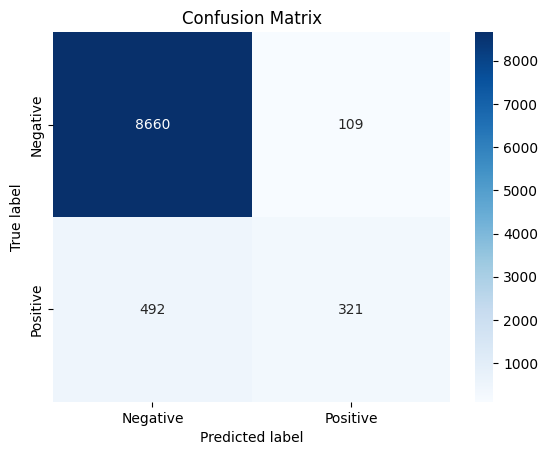

              precision    recall  f1-score   support

    Negative       0.95      0.99      0.97      8769
    Positive       0.75      0.39      0.52       813

    accuracy                           0.94      9582
   macro avg       0.85      0.69      0.74      9582
weighted avg       0.93      0.94      0.93      9582



In [14]:
train_and_test_classifier(pipeline_id = "A652_T")

Loading train/val/test datasets from ../data/datasets/A652.pickle.
Shapes of train/val/test data matrices: (10012, 3, 8)/(2506, 3, 8)/(9582, 3, 8)
Shapes before reshaping:  (10012, 3, 8) (9582, 3, 8)
Shapes after reshaping:  (10012, 24) (9582, 24)


/home/ebezerra/anaconda3/envs/atmoseer/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


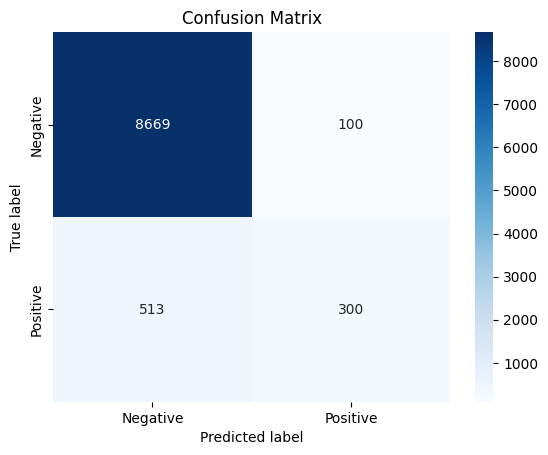

              precision    recall  f1-score   support

    Negative       0.94      0.99      0.97      8769
    Positive       0.75      0.37      0.49       813

    accuracy                           0.94      9582
   macro avg       0.85      0.68      0.73      9582
weighted avg       0.93      0.94      0.93      9582



In [8]:
train_and_test_classifier(pipeline_id = "A652")

In [6]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np 

def train_pilot_model(X_train, y_train):
    y_eq_zero_idxs = np.where(y_train == 0)[0]
    y_gt_zero_idxs = np.where(y_train > 0)[0]
    print(f"Amounts of neg/pos examples: {len(y_eq_zero_idxs)}/{len(y_gt_zero_idxs)}")

    positive_examples = X_train[y_gt_zero_idxs]
    negative_examples = X_train[y_eq_zero_idxs]

    num_positive_examples = len(positive_examples)
    num_negative_examples = len(negative_examples)
    desired_num_examples = min(num_positive_examples, num_negative_examples)
    print(desired_num_examples)

    positive_indices = np.random.choice(num_positive_examples, size=desired_num_examples, replace=False)
    negative_indices = np.random.choice(num_negative_examples, size=desired_num_examples, replace=False)

    X_balanced = np.concatenate((positive_examples[positive_indices], negative_examples[negative_indices]))
    y_balanced = np.concatenate((np.ones(desired_num_examples), np.zeros(desired_num_examples)))

    assert len(y_balanced) == 2*desired_num_examples

    # Create a GradientBoostingClassifier object with default hyperparameters
    clf = GradientBoostingClassifier()

    # Train the classifier on the training data
    clf.fit(X_balanced, y_balanced)
    
    return clf, X_balanced, y_balanced

def score_negative_examples(clf, X_balanced, y_balanced):
    X_balanced_negative = X_balanced[y_balanced==0]
    y_balanced_negative = y_balanced[y_balanced==0]

    # Get predicted probabilities on the negative samples
    y_proba = clf.predict_proba(X_balanced_negative)

    # The predicted probabilities for the negative class (class 0) are in the first column
    y_proba_negative = y_proba[:, 0]

    # Normalize the probabilities to sum to 1
    y_proba_normalized = y_proba_negative / np.sum(y_proba_negative)

    print(f"Normalized scores for the first 5 negative examples: {y_proba_normalized[:5]}")
    print(f"Correct labels for the first 5 negative examples: {y_balanced_negative[:5]}")
    
    return y_proba_normalized

def sample_from_negative_examples(X_balanced, y_balanced, y_proba_normalized):
    # Create an array of indices corresponding to X_balanced_negative
    X_balanced_negative = X_balanced[y_balanced==0]
    indices = np.arange(len(X_balanced_negative))

    positive_examples = X_balanced[y_balanced==1]
    num_positive_examples = len(positive_examples)

    # Sample the indices using the normalized probabilities
    sampled_indices = np.random.choice(indices, size=num_positive_examples, replace=False, p=y_proba_normalized)

    # Use the sampled indices to get a subset "hard" negative examples
    X_sampled_negative = X_balanced_negative[sampled_indices]

    return X_sampled_negative

In [7]:
def apply_negative_sampling(X_train, y_train):
    original_shape_X_train = X_train.shape
    
    X_train = X_train.reshape(len(X_train), -1)
    y_train[y_train>0] = 1    
    
    ###
    # Now apply the steps of the negative sampling procedure
    ###

    # Step 1: Train "pilot" model
    clf, X_balanced, y_balanced = train_pilot_model(X_train, y_train)

    # Step 2: Score the negative examples with the pilot model
    y_proba_normalized = score_negative_examples(clf, X_balanced, y_balanced)

    # Step 3: Sample the negative examples proportionally to the scores
    X_sampled_negative = sample_from_negative_examples(X_balanced, y_balanced, y_proba_normalized)
    
    positive_examples = X_balanced[y_balanced==1]
    desired_num_examples = len(positive_examples)
    X_train_sampled = np.concatenate((positive_examples, X_sampled_negative))
    y_train_sampled = np.concatenate((np.ones(desired_num_examples), np.zeros(desired_num_examples)))
    X_train_sampled.shape, y_train_sampled.shape
    
    X_train_sampled = X_train_sampled.reshape((len(X_train_sampled), original_shape_X_train[1], original_shape_X_train[2]))
    
    return X_train_sampled, y_train_sampled

In [8]:
X_train_sampled, y_train_sampled = apply_negative_sampling(X_train, y_train)

X_train_sampled.shape, y_train_sampled.shape

Amounts of neg/pos examples: 6967/6967
6967
Normalized scores for the first 5 negative examples: [9.52378475e-05 1.06634406e-04 1.69036623e-04 1.62617598e-04
 1.72665145e-04]
Correct labels for the first 5 negative examples: [0. 0. 0. 0. 0.]


((13934, 6, 23), (13934,))

# Train a classifier on the sampled training set

Shapes before reshaping:  (13934, 6, 23) (10228, 6, 23)
Shapes after reshaping:  (13934, 138) (10228, 138)


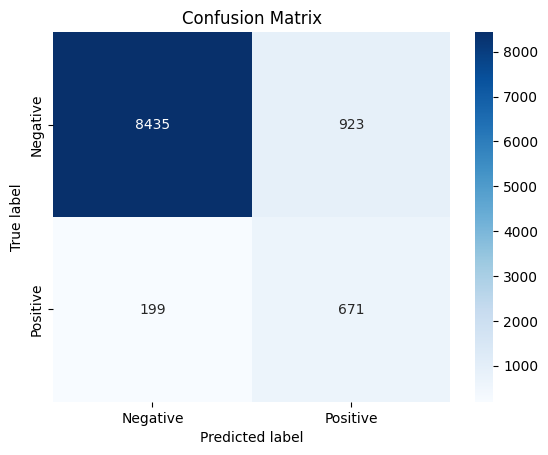

              precision    recall  f1-score   support

    Negative       0.98      0.90      0.94      9358
    Positive       0.42      0.77      0.54       870

    accuracy                           0.89     10228
   macro avg       0.70      0.84      0.74     10228
weighted avg       0.93      0.89      0.90     10228



In [9]:
train_and_test_classifier(X_train_sampled, y_train_sampled, X_test, y_test)

In [ ]:
import pandas as pd
df = pd.read_csv("../data/ws/INMET_WS_Stations.csv")
df.head(30)

In [ ]:
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(point1, point2):
    R = 6371  # Earth's radius in kilometers
    lat1, lon1 = point1
    lat2, lon2 = point2
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

def distance_matrix(point, points_list):
    matrix = []
    for p in points_list:
        distance = haversine_distance(point, p)
        matrix.append(distance)
    return matrix

point = (52.2296756, 21.0122287)  # Warsaw, Poland
points_list = [(51.5073509, -0.1277583),  # London, UK
               (40.7127281, -74.0060152),  # New York City, USA
               (48.856614, 2.3522219)]    # Paris, France

matrix = distance_matrix(point, points_list)
print(matrix)  # output: [1464.580386325907, 6698.945740763303, 1319.1667457437978]


In [ ]:
A652_Latitude = -22.98833333
A652_Longitude = -43.19055555
A652_point = (A652_Latitude, A652_Longitude)

print("Distances from A652 to all other INMET weather stations located in RJ:")
for index, row in df.iterrows():
    longitude = float(row['VL_LONGITUDE'].replace(',','.'))
    latitude = float(row['VL_LATITUDE'].replace(',','.'))
    ws_name = row['DC_NOME']
    ws_point = (latitude, longitude)
    dist = haversine_distance(A652_point, ws_point)
    print(f"{dist}\t {ws_name}")

In [ ]:
gig_Latitude = -22.809167
gig_Longitude = -43.250556
gig_point = (gig_Latitude, gig_Longitude)

print("Distances from SBGL to INMET weather stations located in RJ:")
for index, row in df.iterrows():
    longitude = float(row['VL_LONGITUDE'].replace(',','.'))
    latitude = float(row['VL_LATITUDE'].replace(',','.'))
    ws_name = row['DC_NOME']
    ws_point = (latitude, longitude)
    dist = haversine_distance(gig_point, ws_point)
    print(f"{dist}\t {ws_name}")

In [ ]:
df[['CD_ESTACAO', 'DC_NOME', 'DT_INICIO_OPERACAO']]

In [ ]:
import pandas as pd
df_A621 = pd.read_csv("../data/ws/A621.csv")
df_A621.info()

In [ ]:
df_A621[df_A621.CHUVA>=5].shape, df_A621[df_A621.CHUVA>=25].shape, df_A621[df_A621.CHUVA>=50].shape

In [4]:
import pandas as pd

# Create a sample dataframe with missing values
data = {
    'A': [1, 2, None, 4, 5],
    'B': [6, None, 8, 9, 10],
    'C': [11, 12, 13, None, 15]
}
df = pd.DataFrame(data)

# Compute the percentage of missing values
percentage_missing = (df.isna().mean() * 100).mean()

print(percentage_missing)


20.0
